# Deep learning notebook
This notebook shows the training and evaluation of monai deep learning architectures for semantic segmentation of LIVECell.

Prerequisites to running this:
- Install dependencies from `environment.yml`
- Download the dataset or have the default subset in place.
- Generate the semantic segmentation masks using `instance2semantic.py`

In [1]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os
import numpy as np
import tqdm
import time

# MONAI
import monai
from monai.networks.nets import UNet, VNet, SwinUNETR
from monai.networks.layers import Norm
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandRotate90d,
    RandSpatialCropd,
    ScaleIntensityd,
    RandFlipd,
    RandCropByPosNegLabeld,
    apply_transform
)

from monai.data import CacheDataset, DataLoader, decollate_batch, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, MeanIoU, MSEMetric
from monai.optimizers import WarmupCosineSchedule

import torch

try:
    import wandb
    use_wandb=False # Set this to true if you want to use wandb
except ImportError:
    use_wandb=False

## Explore Dataset

In [2]:
data_path = "dataset/images/livecell_train_val_images/"
annot_path = "dataset/livecell_coco_val.json"

In [3]:
coco=COCO(annot_path)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


MCF7_Phase_F4_2_00d00h00m_4.tif
MCF7_Phase_G4_2_02d16h00m_1.tif
MCF7_Phase_F4_2_00d00h00m_4.tif
BT474_Phase_C3_1_01d04h00m_4.tif


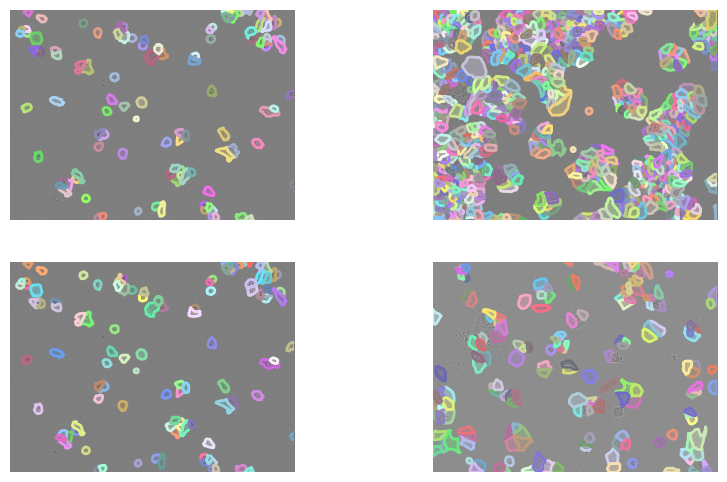

In [4]:
plt.figure(figsize=(10,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    img_ids = coco.getImgIds()
    img = coco.loadImgs([np.random.choice(img_ids)])[0]

    print(img["file_name"])
    I = plt.imread(os.path.join(data_path, img["file_name"]))
    plt.imshow(I, cmap="gray");plt.axis("off")
    ann_ids = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(ann_ids)
    coco.showAnns(anns)

There seems to be some missing labels in some cases.

### Confluence Labels

In [5]:
import seaborn as sns

In [6]:
masks_dir = "dataset/images/livecell_train_val_masks/"
confluences = list()
for mask_path in os.listdir(masks_dir):
    mask = plt.imread(os.path.join(masks_dir, mask_path))
    num_pixels = np.prod(mask.shape)
    num_white = np.sum(mask)
    confluences.append(num_white/num_pixels)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



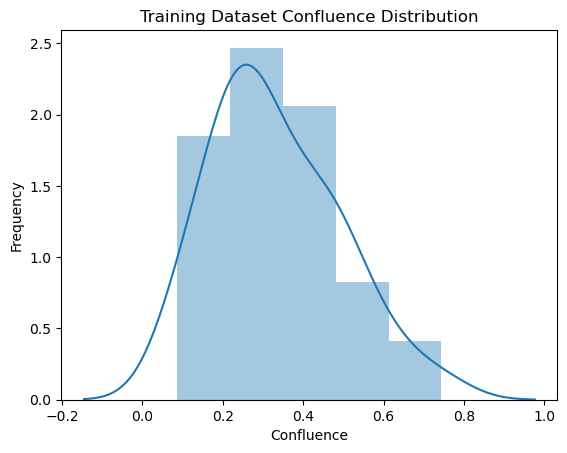

In [7]:
sns.distplot(confluences)
plt.ylabel("Frequency")
plt.xlabel("Confluence")
plt.title("Training Dataset Confluence Distribution")
plt.show()

## Configuration

In [8]:
config = dict(
    roi_size = (96, 96),
    num_samples = 4,
    lr = 1e-4,
    bs = 16,
    epochs = 1, # Set to 1 for testing. Its 100 usually.
    momentum = 0.9
)

In [9]:
if use_wandb:
    run = wandb.init(project="livecell", name="unet-6L-3R-ADAM1e4", config=config)

## Define Transforms

In [10]:
train_trans = [
    LoadImaged(keys=["image", "label"], ensure_channel_first=True),
    ScaleIntensityd(keys=["image", "label"]),
    RandCropByPosNegLabeld(
        keys=["image", "label"], label_key="label", spatial_size=config["roi_size"],
        pos=1, neg=1, num_samples=config["num_samples"]
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 1]),
    #RandSpatialCropd(keys=["image", "label"], roi_size=(96, 96), random_size=True),
    #RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(0, 1)),
]

val_trans = [LoadImaged(keys=["image", "label"], ensure_channel_first=True),
             ScaleIntensityd(keys=["image", "label"])]

train_trans = Compose(train_trans)

val_trans = Compose(val_trans)

infer_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

## Define/Choose Model Architecture

Run one of the cells that contain the model that you want to choose or define your own model.

If you run all cells only the last model will be used which is completely fine as well.

In [11]:
device = "cuda"

In [12]:
# UNet 2L-0R
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 256),
    strides=(2,),
    num_res_units=0,
    norm=Norm.BATCH,
).to(device)

In [13]:
# UNet 4L-0R
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256),
    strides=(2, 2, 2),
    num_res_units=0,
    norm=Norm.BATCH,
).to(device)

In [14]:
# UNet 6L-0R
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=0,
    norm=Norm.BATCH,
).to(device)

In [15]:
# UNet 6L-3R
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)

In [16]:
# VNet
model = VNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1
).to(device)

In [17]:
# SwinUNETR
model = SwinUNETR(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    img_size=config["roi_size"]
).to(device)

## Define Loss and Optimizer

In [19]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), config["lr"])
#optimizer = torch.optim.SGD(model.parameters(),  config["lr"], momentum=0.9, nesterov=True)
dice_metric = DiceMetric()
iou_metric = MeanIoU()
#lr_sched = WarmupCosineSchedule(optimizer, warmup_steps=10, t_total=config["epochs"], )

## Define Dataset and Loaders

In [20]:
path = "dataset/images/livecell_train_val_{}/"
images_path = path.format("images")
masks_path = path.format("masks")

train_annot_path = "dataset/livecell_coco_train.json"
val_annot_path = "dataset/livecell_coco_val.json"

train_coco = COCO(train_annot_path)
val_coco = COCO(val_annot_path)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [21]:
train_images = [os.path.join(images_path, train_coco.loadImgs(x)[0]["file_name"]) for x in train_coco.getImgIds()]
train_masks = [os.path.join(masks_path, train_coco.loadImgs(x)[0]["original_filename"]) for x in train_coco.getImgIds()]

val_images = [os.path.join(images_path, val_coco.loadImgs(x)[0]["file_name"]) for x in val_coco.getImgIds()]
val_masks = [os.path.join(masks_path, val_coco.loadImgs(x)[0]["original_filename"]) for x in val_coco.getImgIds()]

train_files = [
    {"image": i, "label": m}
    for i, m in zip(train_images, train_masks)
]
val_files = [
    {"image": i, "label": m}
    for i, m in zip(val_images, val_masks)
]

In [22]:
del train_coco
del val_coco

In [23]:
train_ds = CacheDataset(data=train_files, transform=train_trans, cache_rate=0.25, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=config["bs"], shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_trans, cache_rate=0.25, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=config["bs"]//2, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.96it/s]


## Training
This takes a few hours so at this point feel free to skip to testing.

In [24]:
class_labels = {0: "BG", 1: "Cell"}

In [25]:
best_metric = -1
best_metric_epoch = -1


num_epochs = config["epochs"]

for epoch in range(num_epochs):
    
    model.train()
    epoch_loss = 0
    step = 0
    t0 = time.time()
    for batch_data in tqdm.tqdm(train_loader):
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        train_outputs = [infer_trans(i) for i in decollate_batch(outputs)]
        dice_metric(y_pred=train_outputs, y=labels)
        iou_metric(y_pred=train_outputs, y=labels)

    epoch_loss /= step
    
    train_dice = dice_metric.aggregate().item()
    train_iou = iou_metric.aggregate().item()
    
    dice_metric.reset()
    iou_metric.reset()
    train_time = time.time() - t0
    
    t0 = time.time()
    model.eval()
    with torch.no_grad():
        val_images = None
        val_labels = None
        val_outputs = None
        for val_data in tqdm.tqdm(val_loader):
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            sw_batch_size = config["num_samples"]
            val_outputs = sliding_window_inference(val_images, config["roi_size"], sw_batch_size, model)

            val_outputs = [infer_trans(i) for i in decollate_batch(val_outputs)]

            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
            iou_metric(y_pred=val_outputs, y=val_labels)

        # aggregate the final mean dice result
        val_dice = dice_metric.aggregate().item()
        val_iou = iou_metric.aggregate().item()
        
        # reset the status 
        dice_metric.reset()
        iou_metric.reset()
                
        metric = val_dice
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            if use_wandb:
                model_name = f"{run.name}_best.pth"
            else:
                model_name = "model_best.pth"
            torch.save(model.state_dict(), model_name)
            if use_wandb:
                torch.save(model.state_dict(), os.path.join(wandb.run.dir, model_name))
            print("saved new best metric model")

        val_time = time.time() - t0
        
        print(f"Epoch {epoch+1}/{num_epochs}: Time: T={train_time:.1f}s,V={val_time:.1f}s, Loss: T={epoch_loss:.3f}\nIoU: T={train_iou:.3f},V={val_iou:.3f}"
              f" Dice: T={train_dice:.3f},V={val_dice:.3f},Best={best_metric:.3f} at epoch {best_metric_epoch}")
        
        if use_wandb:
            wandb.log({
                "train_time": train_time,
                "val_time": val_time,
                "train_loss": epoch_loss,
                "train_iou": train_iou,
                "val_iou": val_iou,
                "train_dice": train_dice,
                "val_dice": val_dice,
                #**to_log
            }, step=epoch+1)
        
        #lr_sched.step(epoch+1)

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

  0%|                                                                                                                 | 0/2 [00:00<?, ?it/s]TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
100%|███████████████████████████████████████

saved new best metric model
Epoch 1/1: Time: T=8.7s,V=8.9s, Loss: T=0.656
IoU: T=0.185,V=0.216 Dice: T=0.309,V=0.350,Best=0.350 at epoch 1
train completed, best_metric: 0.3498 at epoch: 1


In [26]:
if use_wandb:
    run.finish()

## Testing
Here we evaluate on the test set.

In [27]:
model.load_state_dict(torch.load("models/swinunetr-ADAM1e4_best.pth"))

<All keys matched successfully>

In [28]:
path = "dataset/images/livecell_test_{}"
images_path = path.format("images")
masks_path = path.format("masks")

test_annot_path = "dataset/livecell_coco_test.json"

test_coco = COCO(test_annot_path)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [29]:
test_images = [os.path.join(images_path, test_coco.loadImgs(x)[0]["file_name"]) for x in test_coco.getImgIds()]
test_masks = [os.path.join(masks_path, test_coco.loadImgs(x)[0]["original_filename"]) for x in test_coco.getImgIds()]

test_files = [
    {"image": i, "label": m}
    for i, m in zip(test_images, test_masks)
]

test_trans = Compose([LoadImaged(keys=["image", "label"], ensure_channel_first=True),
             ScaleIntensityd(keys=["image", "label"])])

infer_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

test_ds = CacheDataset(data=test_files, transform=test_trans, cache_rate=0.25, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.66it/s]


In [30]:
def compute_confluence(labels_batch):
    return torch.sum(labels_batch, dim=[-3, -2, -1])/np.prod(labels_batch.shape[1:])

In [31]:
model.eval()
dice_metric = DiceMetric()
iou_metric = MeanIoU()
mse_metric = MSEMetric()
with torch.no_grad():

    for test_data in tqdm.tqdm(test_loader):
        test_images_batch, test_labels_batch = test_data["image"].to(device), test_data["label"].to(device)
        test_confluence_labels_batch = compute_confluence(test_labels_batch)
            
        sw_batch_size = config["num_samples"]
        test_outputs = sliding_window_inference(test_images_batch, config["roi_size"], sw_batch_size, model)

        test_outputs = list_data_collate([infer_trans(i) for i in decollate_batch(test_outputs)])
        test_confluence_predictions_batch = compute_confluence(test_outputs)

        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels_batch)
        iou_metric(y_pred=test_outputs, y=test_labels_batch)
        mse_metric(y_pred=torch.unsqueeze(test_confluence_predictions_batch, 1),
                   y=torch.unsqueeze(test_confluence_labels_batch, 1)).shape
    # aggregate the final mean dice result
    test_dice = dice_metric.aggregate().item()
    test_iou = iou_metric.aggregate().item()
    test_conf_mse = mse_metric.aggregate().item()
    
print(f"Testing IoU: {test_iou:.3f}, Dice: {test_dice:.3f}")
print(f"Confluence Prediction MSE {test_conf_mse:.3f}, RMSE {np.sqrt(test_conf_mse):.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.66s/it]

Testing IoU: 0.879, Dice: 0.934
Confluence Prediction MSE 0.005, RMSE 0.074


## Visualize Trained Model outputs

We plot a few random examples to gain intution on how the model is performing.

This block also shows you how to run the model on a single image for inference.

Feel free to run multiple times to look at different samples or increase the loop length.

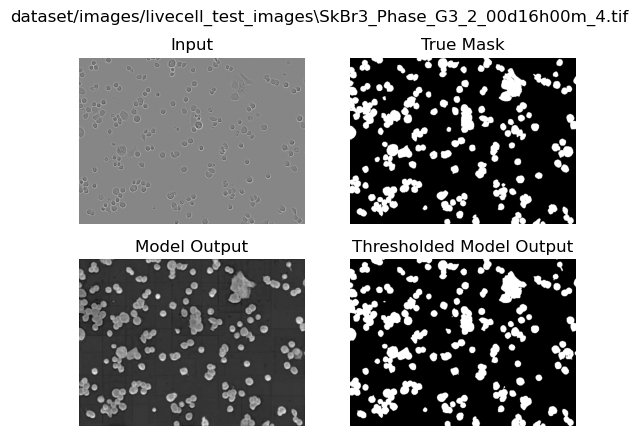

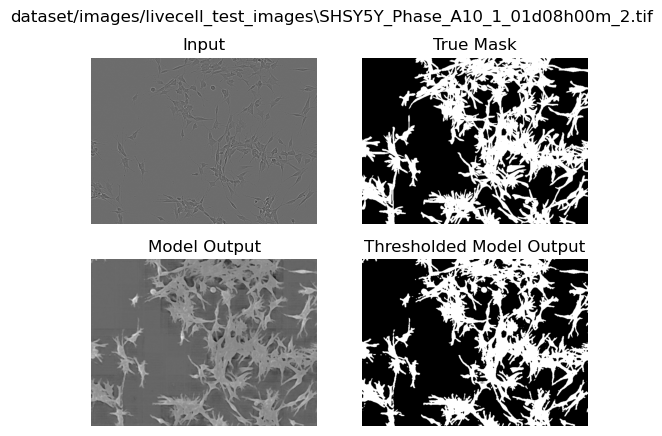

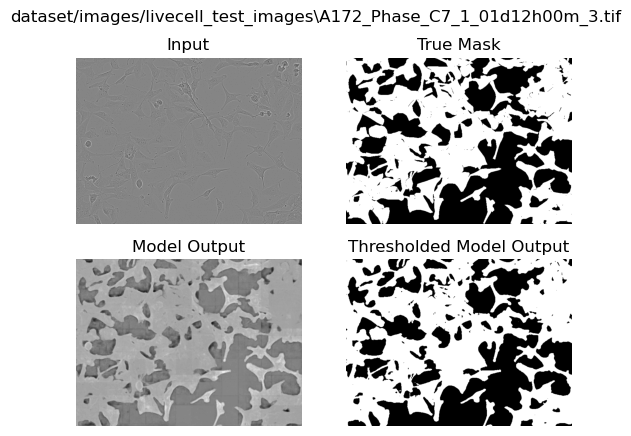

In [32]:
for _ in range(3):
    i = np.random.randint(len(test_images))
    file = {"image": test_images[i], "label": test_masks[i]}
    out_trans = val_trans(file)
    outputs = sliding_window_inference(torch.unsqueeze(out_trans["image"], 0).to(device),
                                       config["roi_size"], config["num_samples"], model)

    plt.subplot(2,2,1)
    plt.imshow(plt.imread(file["image"]), cmap="gray");plt.axis("off")
    plt.title("Input")
    plt.subplot(2,2,2)
    plt.imshow(plt.imread(file["label"]), cmap="gray");plt.axis("off")
    plt.title("True Mask")
    toutput = infer_trans(outputs)
    plt.subplot(2,2,3)
    plt.imshow(outputs[0,0].to("cpu").detach().numpy().T, cmap="gray");plt.axis("off")
    plt.title("Model Output")
    plt.subplot(2,2,4)
    plt.imshow(toutput[0,0].to("cpu").detach().numpy().T, cmap="gray");plt.axis("off")
    plt.title("Thresholded Model Output")
    plt.suptitle(test_images[i])
    plt.show()